I have use the next data set:
    - https://ckan-sobigdata.d4science.org/dataset/gps_track_milan_italy

I am going to analyze high density parking spots in the city of milan to propose to the city where to build more parkings

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings during code execution

import skmob  # Library for spatial mobility data analysis
from skmob.preprocessing import filtering  # skmob module for mobility data filtering
from skmob.preprocessing import compression  # skmob module for mobility data compression
import geopandas as gpd  # Library for handling geospatial data
from skmob.utils import plot  # skmob module for spatial data visualization
import folium  # Library for creating interactive maps based on Leaflet
from folium import plugins  # Additional plugins for interactive maps in Folium
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from folium.plugins import MarkerCluster
import seaborn as sns

## Load the tessellation of the neighborhoods in Milan
- find it here: https://cartographyvectors.com/map/458-milan
- visualize the tessellation (use black for background, red for borders, and a value of 2 for the weight of the borders)

In [2]:
# Local file milan_.geojson
file_path = "milan_.geojson"

# Load geojson file
tessellation = gpd.read_file(file_path)

# Groupby cartodb_id
tessellation = tessellation.explode().groupby("cartodb_id", as_index=False).first()

# Show first lines of tesselation
tessellation.head()

,cartodb_id,name,created_at,updated_at,geometry
0,1,ROSERIO,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.12230 45.51535, 9.12198 45.51522, ..."
1,2,Comasina,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.16922 45.52329, 9.16838 45.52167, ..."
2,3,Stephenson,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.12968 45.50931, 9.13008 45.50872, ..."
3,4,Qt 8,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.14403 45.48407, 9.14373 45.48353, ..."
4,5,Ortomercato,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.23773 45.45521, 9.23766 45.45360, ..."


# Data understanding

In [3]:
tessellation.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   cartodb_id  88 non-null     int64   
 1   name        88 non-null     object  
 2   created_at  88 non-null     object  
 3   updated_at  88 non-null     object  
 4   geometry    88 non-null     geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 3.6+ KB


In [4]:
tessellation.rename(columns={'cartodb_id': 'tile_ID'}, inplace=True)
print(tessellation.shape)
tessellation.head()

(88, 5)


,tile_ID,name,created_at,updated_at,geometry
0,1,ROSERIO,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.12230 45.51535, 9.12198 45.51522, ..."
1,2,Comasina,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.16922 45.52329, 9.16838 45.52167, ..."
2,3,Stephenson,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.12968 45.50931, 9.13008 45.50872, ..."
3,4,Qt 8,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.14403 45.48407, 9.14373 45.48353, ..."
4,5,Ortomercato,2013-11-27T21:33:33+01:00,2013-11-27T21:39:29+01:00,"POLYGON ((9.23773 45.45521, 9.23766 45.45360, ..."


In [5]:
tess_style = {'color':'red', 'fillColor':'black', 'weight': 2}
popup_features=['tile_ID','name']
map_f = plot.plot_gdf(tessellation, zoom=12, style_func_args=tess_style, 
             popup_features=popup_features)
map_f

## Load the full private cars data of Milan into a `TrajDataFrame`


Once you uploaded the `TrajDataFrame`, print:
- the number of records
- the number of users
- the period of time covered by the dataset



In [6]:
%time
# Define data parser for the column 'datetime' to datetime
mydateparser = lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')

# Load CSV file
file_path = "MilanoData.csv"
tdf = skmob.TrajDataFrame(pd.read_csv(file_path, parse_dates=['datetime'], date_parser=mydateparser), 
                          latitude='lat', longitude='lon', datetime='datetime', user_id='userid')
# sorting values by user and datetime
tdf = tdf.sort_values(by=['uid', 'datetime'])

# Showing statistics
print('Records: %s' % len(tdf))
print('Users: %s' % len(tdf['uid'].unique()))
print('Period: %s - %s' % (tdf.datetime.min(), tdf.datetime.max()))

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 21.9 µs
Records: 1806293
Users: 17087
Period: 2007-04-01 00:00:02 - 2007-04-07 23:59:25


In [7]:
print(tdf.shape)
tdf.head()

(1806293, 4)


,uid,datetime,lat,lng
742573,193,2007-04-03 08:01:00,45.377006,9.277484
742574,193,2007-04-03 08:01:55,45.391857,9.261229
742575,193,2007-04-03 08:03:16,45.409712,9.262036
742576,193,2007-04-03 08:05:52,45.415662,9.265230
742577,193,2007-04-03 10:10:51,45.423224,9.275968


In [8]:
from skmob.measures.individual import maximum_distance

In [9]:
md_df = maximum_distance(tdf)

100%|███████████████████████████████████| 17087/17087 [00:06<00:00, 2479.16it/s]


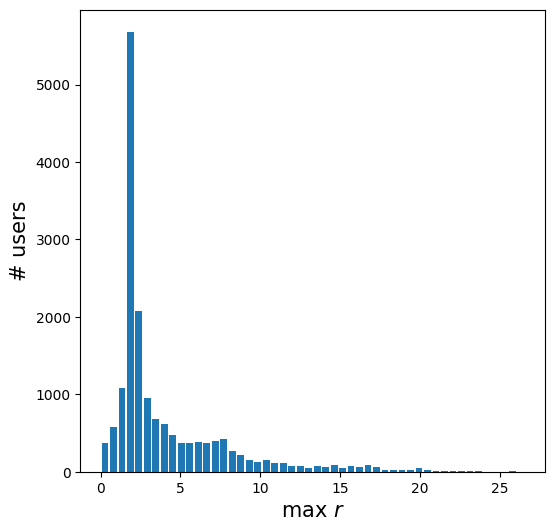

In [10]:
# let's plot the histogram
fig = plt.figure(figsize=(6, 6))
plt.hist(md_df['maximum_distance'], bins=50, rwidth=0.8)
plt.xlabel('max $r$', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

### Select the first 10000 users so we have a reasonable amount of data

In [11]:
tdf = tdf[tdf['uid'].isin(tdf['uid'].unique()[:10000])]
print(tdf.shape)
tdf.head()

(1035722, 4)


,uid,datetime,lat,lng
742573,193,2007-04-03 08:01:00,45.377006,9.277484
742574,193,2007-04-03 08:01:55,45.391857,9.261229
742575,193,2007-04-03 08:03:16,45.409712,9.262036
742576,193,2007-04-03 08:05:52,45.415662,9.265230
742577,193,2007-04-03 10:10:51,45.423224,9.275968


## Filter the trajectories
using `max_speed_kmh=150.0`

Print:
- how many points the new `TrajDataFrame` has
- how many points have been filtered out

In [12]:
%%time
f_tdf = filtering.filter(tdf, max_speed_kmh=150.0)
print('Number of records:\t%s'%len(f_tdf))
print('Filtered points:\t%s'%(len(tdf) - len(f_tdf)))

Number of records:	1034952
Filtered points:	770
CPU times: user 11.2 s, sys: 567 ms, total: 11.8 s
Wall time: 11.3 s


## Compress the filtered trajectories

using `spatial_radius_km=0.2`

Print:
- how many points the new `TrajDataFrame` has
- how many points have been compressed

In [13]:
%%time
fc_tdf = compression.compress(f_tdf, spatial_radius_km=0.2)
print('Points of the filtered trajectory:\t%s'%len(f_tdf))
print('Points of the compressed trajectory:\t%s'%len(fc_tdf))
print('Compressed points:\t\t\t%s'%(len(f_tdf)-len(fc_tdf)))

Points of the filtered trajectory:	1034952
Points of the compressed trajectory:	806284
Compressed points:			228668
CPU times: user 20.9 s, sys: 83.3 ms, total: 20.9 s
Wall time: 21 s


## Detecting stops for each user

using `minutes_for_a_stop=30.0` and `spatial_radius_km=0.3`

In [14]:
from skmob.preprocessing import detection

In [15]:
fcs_tdf = detection.stay_locations(fc_tdf, minutes_for_a_stop=30, spatial_radius_km=0.3)

fcs_tdf.head()

,uid,datetime,lat,lng,leaving_datetime
0,193,2007-04-03 08:05:52,45.415662,9.265230,2007-04-03 10:10:51
1,193,2007-04-03 10:17:23,45.437518,9.231097,2007-04-03 11:59:30
2,193,2007-04-03 12:01:53,45.431064,9.266437,2007-04-03 14:18:19
3,193,2007-04-03 14:18:19,45.416912,9.260658,2007-04-03 15:45:41
4,193,2007-04-03 15:45:41,45.417499,9.266005,2007-04-04 11:18:24


## Mapping the stops in city of Milan on to the tessellation

The mapping operation associates at each point of the `TrajDataFrame` the corresponding tile.


In [16]:
map_fcs_tdf = fcs_tdf.mapping(tessellation)
map_fcs_tdf.head()

,uid,datetime,lat,lng,leaving_datetime,tile_ID
0,193,2007-04-03 08:05:52,45.415662,9.265230,2007-04-03 10:10:51,NaN
1,193,2007-04-03 10:17:23,45.437518,9.231097,2007-04-03 11:59:30,39.0
2,193,2007-04-03 12:01:53,45.431064,9.266437,2007-04-03 14:18:19,NaN
3,193,2007-04-03 14:18:19,45.416912,9.260658,2007-04-03 15:45:41,NaN
4,193,2007-04-03 15:45:41,45.417499,9.266005,2007-04-04 11:18:24,NaN


In [17]:
#ploting stops areas of parking from data
tess_style = {'color':'red', 'fillColor':'black', 'weight': 2}
popup_features=['tile_ID', 'name']
map_f = plot.plot_gdf(tessellation, zoom=12, style_func_args=tess_style, 
             popup_features=popup_features)
map_f = map_fcs_tdf.plot_stops(map_f=map_f)
map_f

In [18]:
#plotting parking stops that are outside of tiles
tess_style = {'color':'red', 'fillColor':'black', 'weight': 2}
popup_features=['tile_ID', 'name']
map_f = plot.plot_gdf(tessellation, zoom=12, style_func_args=tess_style, 
             popup_features=popup_features)
map_f = map_fcs_tdf[map_fcs_tdf['tile_ID'].isnull()].plot_stops(map_f=map_f)
map_f

In [19]:
#removing NaN from tile_ID
map_fcs_tdf = fcs_tdf.mapping(tessellation, remove_na=True)
map_fcs_tdf.head()

,uid,datetime,lat,lng,leaving_datetime,tile_ID
1,193,2007-04-03 10:17:23,45.437518,9.231097,2007-04-03 11:59:30,39
16,310,2007-04-05 04:36:16,45.467644,9.194924,2007-04-07 23:29:56,35
25,475,2007-04-01 07:55:40,45.488135,9.233124,2007-04-01 13:58:20,72
27,475,2007-04-01 17:44:53,45.487430,9.233258,2007-04-02 17:24:17,72
28,475,2007-04-02 17:36:24,45.488225,9.232903,2007-04-03 16:20:42,72


In [20]:
#Checking if actually take away nan values
map_fcs_tdf['tile_ID'].unique()

array([39, 35, 72, 28,  7, 80, 13, 31, 88, 70, 74, 52, 65, 25, 76, 75, 22,
       60, 42, 20, 50, 54, 79, 38, 10, 19,  1,  9, 29, 33, 82, 61,  8, 11,
       47, 21, 34, 83, 48, 84,  6, 59, 37, 46, 77, 12, 78, 14, 16, 41, 15,
       44, 24, 87, 32, 67, 40, 58, 81,  5,  2, 30, 17, 27, 73, 36, 23,  3,
       56, 69, 68,  4, 71, 51, 26, 49, 57, 53, 45, 66, 18, 64, 55, 62, 43,
       86, 85, 63])

## Detecting high density stops areas

using `min_samples=1` and `cluster_radius_km=0.2`

In [21]:
from skmob.preprocessing import clustering

In [22]:
fcs_tdf_cluster = clustering.cluster(fcs_tdf, cluster_radius_km=0.2, min_samples=1)
fcs_tdf_cluster.head()

,uid,datetime,lat,lng,leaving_datetime,cluster
0,193,2007-04-03 08:05:52,45.415662,9.265230,2007-04-03 10:10:51,6
1,193,2007-04-03 10:17:23,45.437518,9.231097,2007-04-03 11:59:30,5
2,193,2007-04-03 12:01:53,45.431064,9.266437,2007-04-03 14:18:19,4
3,193,2007-04-03 14:18:19,45.416912,9.260658,2007-04-03 15:45:41,3
4,193,2007-04-03 15:45:41,45.417499,9.266005,2007-04-04 11:18:24,0


In [23]:
# Amount of density areas find in the dataset
fcs_tdf_cluster['cluster'].value_counts()

0     31244
1     16414
2      8546
3      5752
4      4309
5      3325
6      2633
7      2076
8      1617
9      1253
10      937
11      734
12      550
13      406
14      317
15      233
16      171
17      134
18      105
19       87
20       61
21       37
22       29
23       26
24       17
25       10
26        8
27        2
28        1
Name: cluster, dtype: int64

In [24]:
#Checking len of data frame and clusters to see if every point has been assaign
print(len(fcs_tdf_cluster),sum(fcs_tdf_cluster['cluster'].value_counts()))

81034 81034


## Mapping high density parking of Milan on to the tessellation

The mapping operation associates at each point of the `TrajDataFrame` the corresponding tile.

In [25]:
map_fcs_tdf_cluster = fcs_tdf_cluster.mapping(tessellation)
map_fcs_tdf_cluster.head()

,uid,datetime,lat,lng,leaving_datetime,cluster,tile_ID
0,193,2007-04-03 08:05:52,45.415662,9.265230,2007-04-03 10:10:51,6,NaN
1,193,2007-04-03 10:17:23,45.437518,9.231097,2007-04-03 11:59:30,5,39.0
2,193,2007-04-03 12:01:53,45.431064,9.266437,2007-04-03 14:18:19,4,NaN
3,193,2007-04-03 14:18:19,45.416912,9.260658,2007-04-03 15:45:41,3,NaN
4,193,2007-04-03 15:45:41,45.417499,9.266005,2007-04-04 11:18:24,0,NaN


In [26]:
#removing NaN from tile_ID
map_fcs_tdf_cluster = fcs_tdf_cluster.mapping(tessellation, remove_na=True)
map_fcs_tdf_cluster

,uid,datetime,lat,lng,leaving_datetime,cluster,tile_ID
1,193,2007-04-03 10:17:23,45.437518,9.231097,2007-04-03 11:59:30,5,39
16,310,2007-04-05 04:36:16,45.467644,9.194924,2007-04-07 23:29:56,0,35
25,475,2007-04-01 07:55:40,45.488135,9.233124,2007-04-01 13:58:20,0,72
27,475,2007-04-01 17:44:53,45.487430,9.233258,2007-04-02 17:24:17,0,72
28,475,2007-04-02 17:36:24,45.488225,9.232903,2007-04-03 16:20:42,0,72
...,...,...,...,...,...,...,...
81008,202148,2007-04-07 09:41:32,45.491414,9.225784,2007-04-07 10:21:53,2,72
81009,202148,2007-04-07 10:21:53,45.482650,9.221112,2007-04-07 14:15:58,1,61
81010,202148,2007-04-07 14:20:54,45.472979,9.196927,2007-04-07 15:56:52,0,57
81027,202261,2007-04-07 09:39:48,45.519499,9.164347,2007-04-07 10:24:40,3,38


### In this map we can see every cluster find from the stops

In [27]:
#ploting stops as clusters with every user and multiple stops of each
tess_style = {'color':'red', 'fillColor':'black', 'weight': 2}
popup_features=['tile_ID', 'name']
map_f = plot.plot_gdf(tessellation, zoom=12, style_func_args=tess_style, 
             popup_features=popup_features)
map_f = map_fcs_tdf_cluster.plot_stops(map_f=map_f)
map_f

In [49]:
map_fcs_tdf_cluster['datetime'] = pd.to_datetime(map_fcs_tdf_cluster['datetime'])
map_fcs_tdf_cluster['leaving_datetime'] = pd.to_datetime(map_fcs_tdf_cluster['leaving_datetime'])
map_fcs_tdf_cluster['duration'] = map_fcs_tdf_cluster['leaving_datetime'] - map_fcs_tdf_cluster['datetime']

# Calcular la duración media por cluster
mean_duration = map_fcs_tdf_cluster.groupby('cluster')['duration'].mean()
mean_duration

cluster
0    0 days 10:34:45.950754244
1    0 days 07:25:58.101333719
2    0 days 04:30:26.439276485
3    0 days 03:48:21.530109890
4    0 days 03:57:21.395375722
5    0 days 03:24:00.995926680
6    0 days 02:59:38.727748691
7    0 days 02:40:11.331896551
8    0 days 02:34:07.018817204
9    0 days 02:56:10.979202772
10   0 days 02:21:13.693627450
11   0 days 02:30:50.231843575
12   0 days 02:28:47.825925925
13   0 days 02:57:38.009900990
14   0 days 02:09:20.339181286
15      0 days 02:29:00.550000
16   0 days 01:57:57.206185567
17   0 days 02:12:02.450704225
18   0 days 01:41:42.762711864
19   0 days 01:30:08.714285714
20   0 days 01:53:59.025641025
21   0 days 00:46:09.071428571
22   0 days 01:52:45.391304347
23   0 days 02:46:07.058823529
24   0 days 01:26:21.545454545
25   0 days 01:35:48.333333333
26      0 days 00:40:57.750000
27             0 days 01:52:17
28             0 days 02:47:22
Name: duration, dtype: timedelta64[ns]

## Plot a cloropleth map of the number of GPS points in each tile

In [28]:
def plot_cloropleth(tdf, tessellation, map_f=None):
   
    if map_f is None:
        m = folium.Map(location=[tdf['lat'].mean(), tdf['lng'].mean()], 
                       zoom_start=11, control_scale=True)
    else:
        m = map_f
    
    
    points_per_tile = tdf.groupby('tile_ID').size().reset_index(name='n_points')
    
    folium.Choropleth(
        geo_data=tessellation.__geo_interface__,
        data=points_per_tile,
        columns=['tile_ID', 'n_points'],
        key_on='feature.properties.tile_ID',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Number of points'
    ).add_to(m)

    
    return m

In [29]:
len(map_fcs_tdf)

35955

In [30]:
map_fcs_tdf_cluster

,uid,datetime,lat,lng,leaving_datetime,cluster,tile_ID
1,193,2007-04-03 10:17:23,45.437518,9.231097,2007-04-03 11:59:30,5,39
16,310,2007-04-05 04:36:16,45.467644,9.194924,2007-04-07 23:29:56,0,35
25,475,2007-04-01 07:55:40,45.488135,9.233124,2007-04-01 13:58:20,0,72
27,475,2007-04-01 17:44:53,45.487430,9.233258,2007-04-02 17:24:17,0,72
28,475,2007-04-02 17:36:24,45.488225,9.232903,2007-04-03 16:20:42,0,72
...,...,...,...,...,...,...,...
81008,202148,2007-04-07 09:41:32,45.491414,9.225784,2007-04-07 10:21:53,2,72
81009,202148,2007-04-07 10:21:53,45.482650,9.221112,2007-04-07 14:15:58,1,61
81010,202148,2007-04-07 14:20:54,45.472979,9.196927,2007-04-07 15:56:52,0,57
81027,202261,2007-04-07 09:39:48,45.519499,9.164347,2007-04-07 10:24:40,3,38


In [52]:
#plotting cloropleth of amount of stop in each neighborhood
tess_style = {'color':'YlgN', 'fillColor':'YlgN', 'weight': 2}
popup_features=['tile_ID', 'name','cluster']
map_f = plot_cloropleth(map_fcs_tdf, tessellation)
map_f = plot.plot_gdf(tessellation, map_f=map_f, zoom=9, style_func_args=tess_style, 
             popup_features=popup_features)

map_f